1. Install Dependencies

In [1]:
# CLIP dependencies
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

# Stable Diffusion dependencies
! pip install diffusers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.2 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-4gs986y1
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-4gs986y1
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 104.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 83.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

2. Imports

In [15]:
import os
import re
from google.colab import drive

from abc import ABC, abstractmethod
from typing import Union, List, Optional

from PIL import Image

import numpy as np
import torch
from torchvision import transforms

from diffusers import DiffusionPipeline, StableDiffusionPipeline, StableDiffusion3Pipeline

import clip

3. Connect to Google Drive

In [3]:
drive.mount("/content/drive",force_remount=True)
os.chdir("/content/drive/My Drive")

Mounted at /content/drive


4. Test Stable Diffusion Model

In [4]:
class ModelLoadingError(Exception):
    """Exception raised when there is an error loading the model."""
    pass

class InferenceError(Exception):
    """Exception raised when an error occurs during inference."""
    pass


In [5]:
class BaseModel(ABC):
    @abstractmethod
    def load_model(self):
        """
        Load the open-weights model or make an API connection to the closed-source model.
        """
        pass

    @abstractmethod
    def inference(
        self, inputs: Union[List[str], torch.Tensor], captions: Optional[List[str]] = None
    ) -> Union[torch.Tensor, List[float]]:
        """
        Run inference on a batch of inputs with optional captions.

        Args:
            inputs (Union[List[str], torch.Tensor]): A batch of text prompts or a batch of images.
            captions (Optional[List[str]]): Optional text captions associated with the inputs for reward models.

        Returns:
            Union[torch.Tensor, List[float]]: A batch of model outputs or a list of reward scores.
        """
        pass

In [6]:
class HPSv1Model(BaseModel):
    def __init__(self, model_path: str):
        """
        Args:
            model_path (str): Path to the HPSv1 model checkpoint.
        """
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.model_path = model_path
        self.load_model()

    def load_model(self):
        try:
            self.model, self.preprocess = clip.load("ViT-L/14", device=self.device)
            checkpoint = torch.load(self.model_path)

            if "state_dict" not in checkpoint:
                raise ModelLoadingError("Checkpoint does not contain 'state_dict'.")

            self.model.load_state_dict(checkpoint["state_dict"])

        except FileNotFoundError as e:
            raise ModelLoadingError(f"Model checkpoint not found at '{self.model_path}'.") from e
        except Exception as e:
            raise ModelLoadingError(f"Error loading model: {e}") from e

    def inference(self, inputs: torch.Tensor, captions: List[str]) -> List[float]:
        """
        Runs inference on a batch of images and corresponding captions.
        Returns a batch of reward scores.
        """
        if not isinstance(inputs, torch.Tensor):
            raise TypeError("Expected 'inputs' to be of type torch.Tensor (i.e. images).")
        if not isinstance(captions, list) or not all(isinstance(c, str) for c in captions):
            raise TypeError("Expected 'captions' to be a list of strings.")
        if inputs.shape[0] != len(captions):
            raise ValueError("Number of 'inputs' and 'captions' must match.")

        try:
            with torch.no_grad():
                image_features = self.model.encode_image(inputs.to(self.device))
                text_tokens = clip.tokenize(captions).to(self.device)
                text_features = self.model.encode_text(text_tokens)

                image_features = image_features / image_features.norm(dim=-1, keepdim=True)
                text_features = text_features / text_features.norm(dim=-1, keepdim=True)

                # Convert cosine similarity scores to percentages as in the original paper
                similarity_scores = (image_features @ text_features.T).diag() * 100

            return similarity_scores.tolist()
        except Exception as e:
            raise InferenceError(f"Inference failed: {e}") from e

In [16]:
class StableDiffusionModel(BaseModel):
    def __init__(self, model_path: str):
        """
        Args:
            model_path (str): Path to the Stable Diffusion model.
                              Must include 'stable-diffusion-1', 'stable-diffusion-2', or 'stable-diffusion-3' after '<repo-owner>/'
                              for simplicity.
        """
        self.seed = 42

        self.model_path = model_path
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.load_model()

    def load_model(self):

        version_tag = self.model_path.split("/")[-1].lower()

        if re.search(r'(stable-diffusion-1|v-?1)', version_tag):
            pipeline_class = StableDiffusionPipeline
        elif re.search(r'(stable-diffusion-2|v-?2)', version_tag):
            pipeline_class = DiffusionPipeline
        elif re.search(r'(stable-diffusion-3|v-?3)', version_tag):
            pipeline_class = StableDiffusion3Pipeline
        else:
            raise ModelLoadingError(
                "Model path must contain one of: 'stable-diffusion-1', 'stable-diffusion-2', or 'stable-diffusion-3'."
            )

        try:
            # Load the model with float16 precision.
            # If your GPU supports torch.bfloat16 for lower memory usage with similar precision to FP32,
            # consider switching the torch_dtype accordingly.
            self.diffusion_pipeline = pipeline_class.from_pretrained(
                self.model_path, torch_dtype=torch.float16
            ).to(self.device)

        except MemoryError as e:
            # Clean up and clear GPU memory if a MemoryError occurs
            if hasattr(self, "model"):
                del self.model
            torch.cuda.empty_cache()
            raise ModelLoadingError(f"Memory error occurred while loading the model. Consider using a smaller model: {e}") from e
        except Exception as e:
            raise ModelLoadingError(f"Failed to load Stable Diffusion model: {e}") from e

    def inference(
        self, inputs: List[str], captions: Optional[List[str]] = None
    ) -> list[torch.Tensor]:
        """
        Runs inference on a batch of prompts.
        Returns a batch of images corresponding to the prompts.
        """
        if not isinstance(inputs, list) or not all(isinstance(c, str) for c in inputs):
            raise TypeError("Expected 'inputs' to be a list of strings.")

        try:
            # Create one generator per prompt to ensure reproducibility
            generators = [
                torch.Generator("cuda").manual_seed(self.seed) for _ in range(len(inputs))
            ]
            images = self.diffusion_pipeline(prompt=inputs, generator=generators).images
            return images

        except Exception as e:
            raise InferenceError(f"Inference failed: {e}")

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

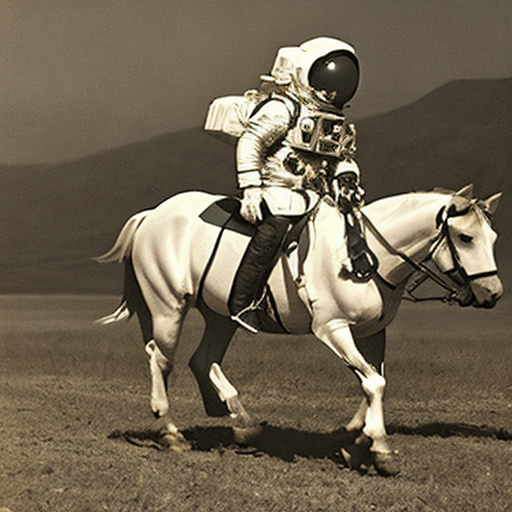

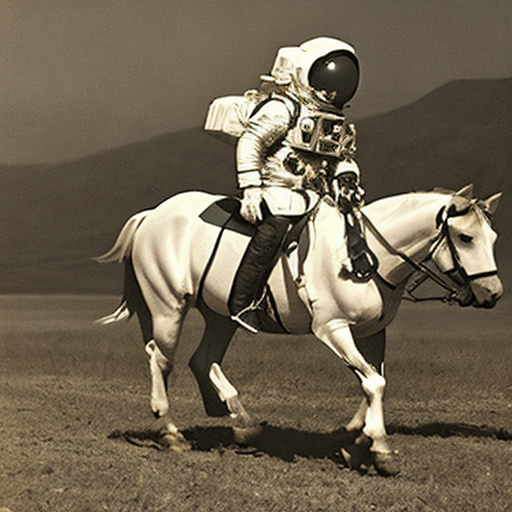

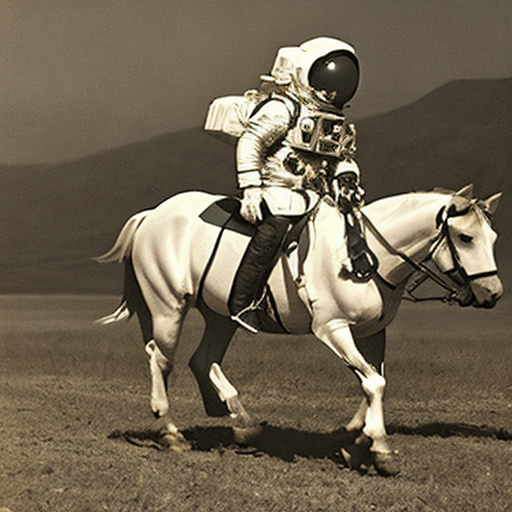

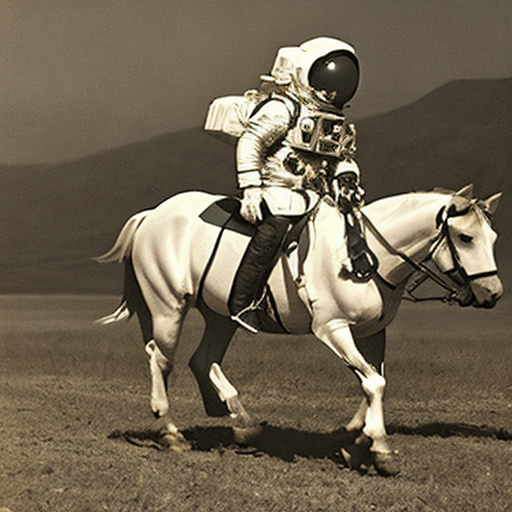

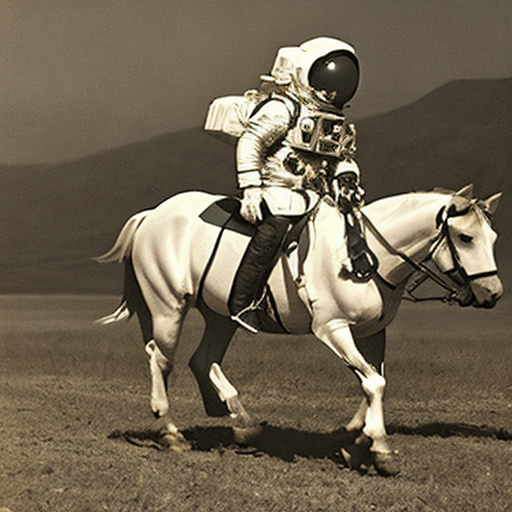

In [17]:
model = StableDiffusionModel(model_path="stabilityai/stable-diffusion-2-1-base")
images = model.inference(inputs=["a photograph of an astronaut riding a horse"] * 5)
for i in range(5):
  display(images[i])